In [1]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np

In [2]:
raw_data = pd.read_csv('../data/output/mannheim_transformed.csv', parse_dates=['start_time'])

In [3]:
university_stations = ['DHBW Mannheim - Campus Coblitzallee',
                       'A5 - Universität West','L1 - Schloss',
                       'DHBW Mannheim - Campus Käfertalerstr.',
                       'Universität Schloss','Universität Mensa',
                       'Universitätsklinik Mannheim - CampusRad',
                       'Hochschule Mannheim']

In [4]:
raw_data.loc[(raw_data['start_position_name'].isin(university_stations)), 'destination']='to_university'
raw_data.loc[(raw_data['end_position_name'].isin(university_stations)), 'destination']='from_university'
raw_data.loc[(raw_data['duration'] <= 180) & (raw_data["start_position"] == raw_data["end_position"]), 'destination'] = 'false'
raw_data.fillna('not_university', inplace=True)

In [5]:
prediction_data = raw_data[['start_time', 'weekend', 'is_station', 'destination']].copy()

In [6]:
# Creating an individual column for hour of the day
prediction_data['HOUR'] = prediction_data.start_time.dt.strftime('%-H').astype('int')

# Creating an individual column for week of the year
prediction_data['WEEK_OF_YEAR'] = prediction_data.start_time.dt.strftime('%W').astype('int')

# Creating an individual column for day of the week
prediction_data['DAY_OF_WEEK'] = prediction_data.start_time.dt.strftime('%w').astype('int')

prediction_data['MONTH'] = prediction_data.start_time.dt.strftime('%m').astype('int')

seasons = []
for month in prediction_data['MONTH']:
    if month in [1, 2, 12]:
        seasons.append(0)
    elif month in [3, 4, 5]:
        seasons.append(1)
    elif month in [6, 7, 8]:
        seasons.append(2)
    elif month in [9, 10, 11]:
        seasons.append(3)
prediction_data['season'] = seasons

prediction_data.drop(columns=['start_time'], inplace=True)

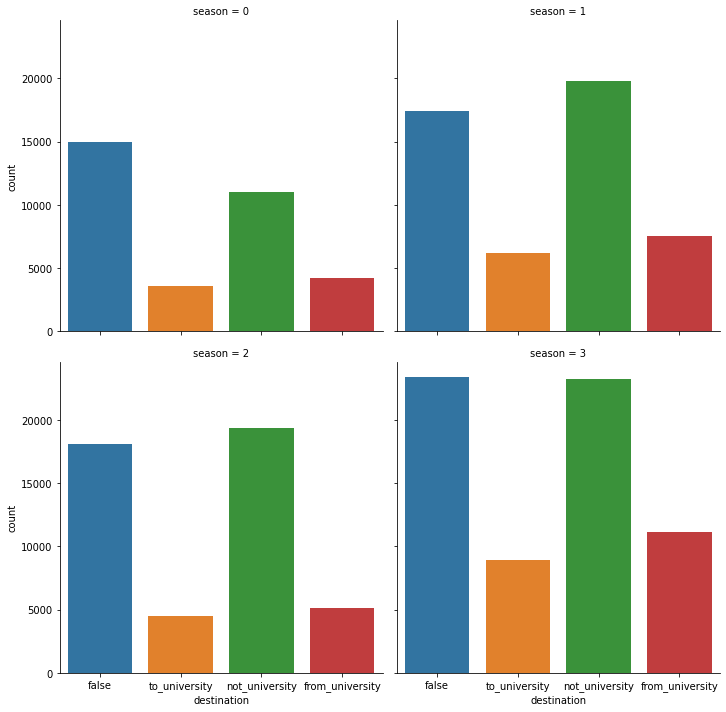

In [7]:
sns.catplot('destination', col='season', data=prediction_data, kind='count', col_wrap=2)

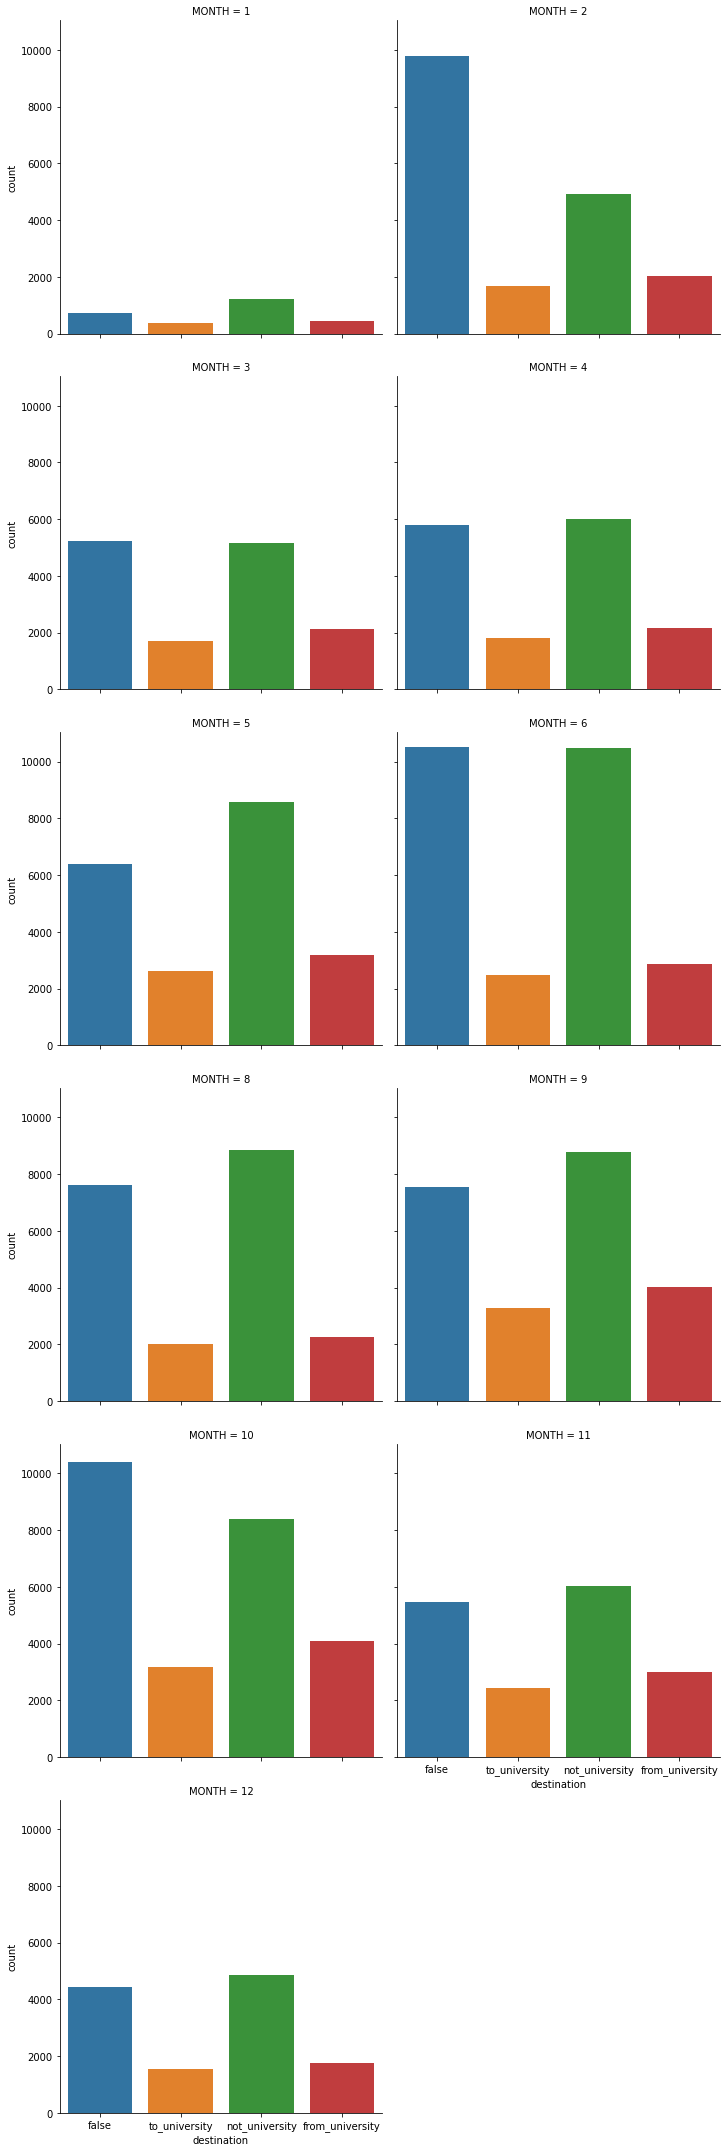

In [8]:
sns.catplot('destination', col='MONTH', data=prediction_data, kind='count', col_wrap=2)

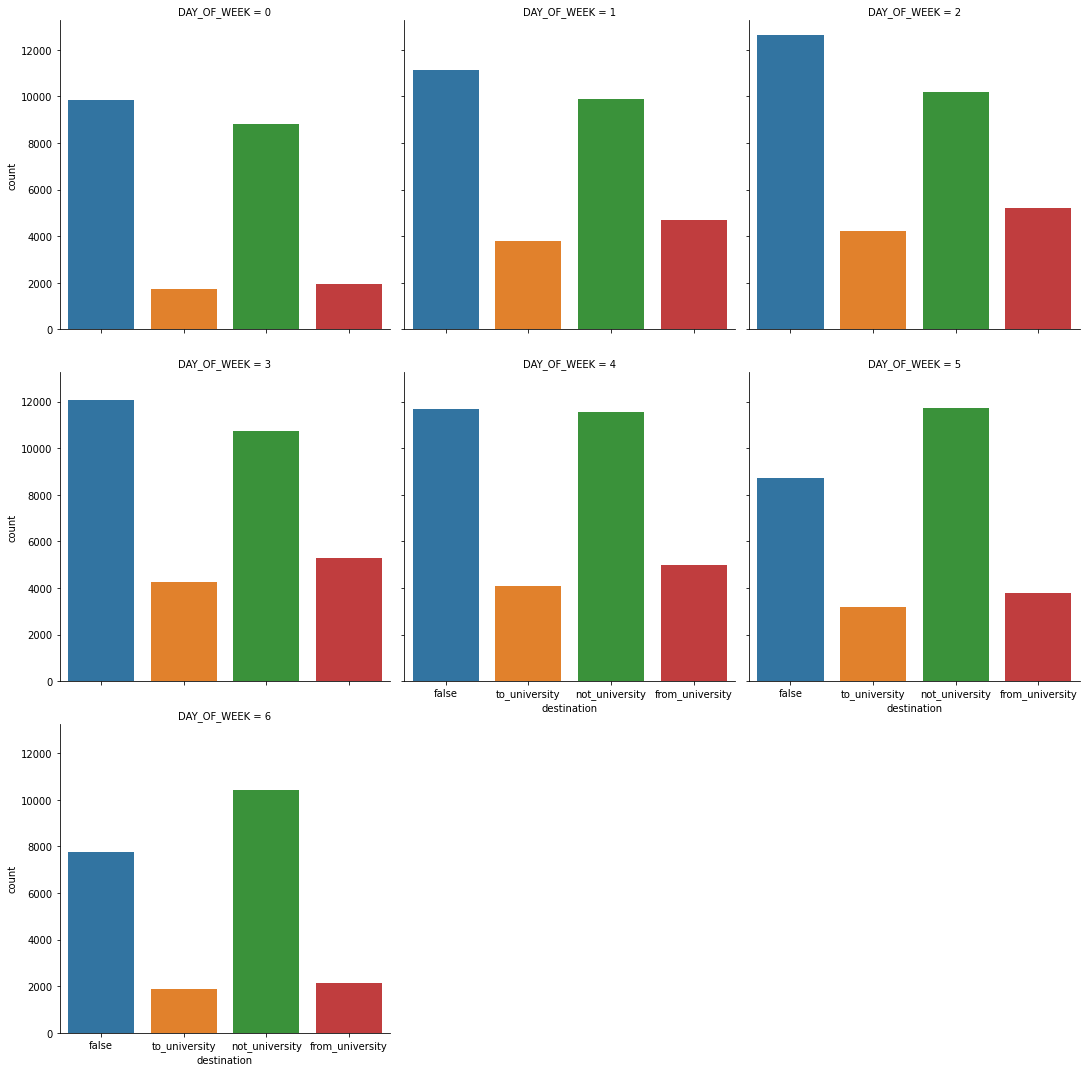

In [9]:
sns.catplot('destination', col='DAY_OF_WEEK', data=prediction_data, kind='count', col_wrap=3)

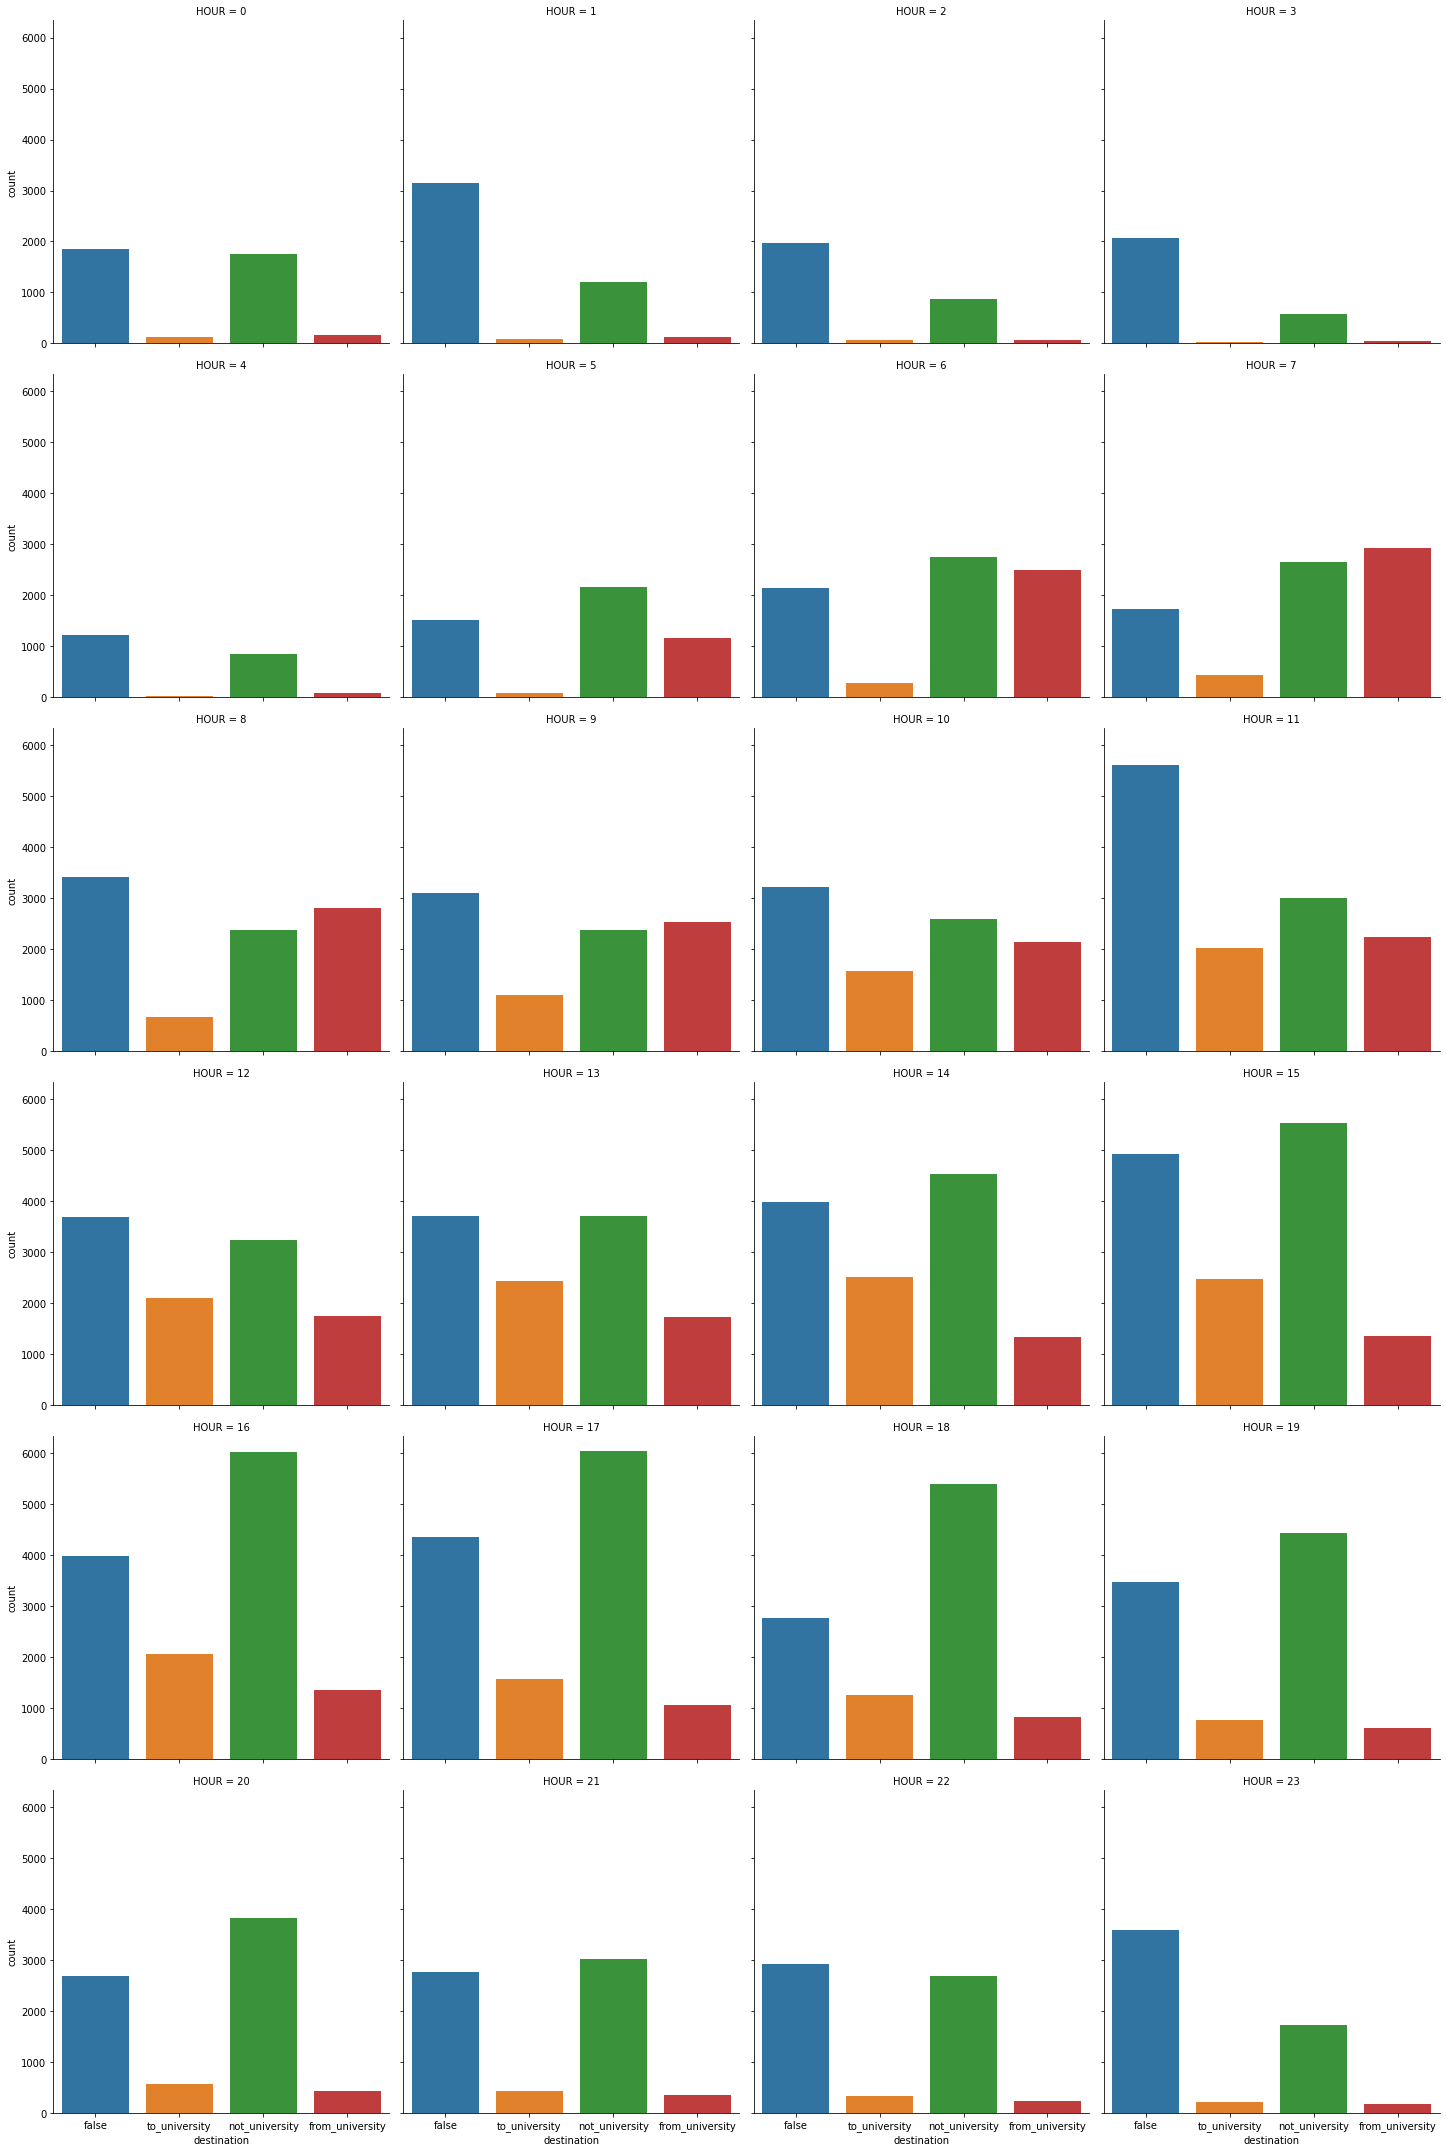

In [10]:
sns.catplot('destination', col='HOUR', data=prediction_data, kind='count', col_wrap=4)

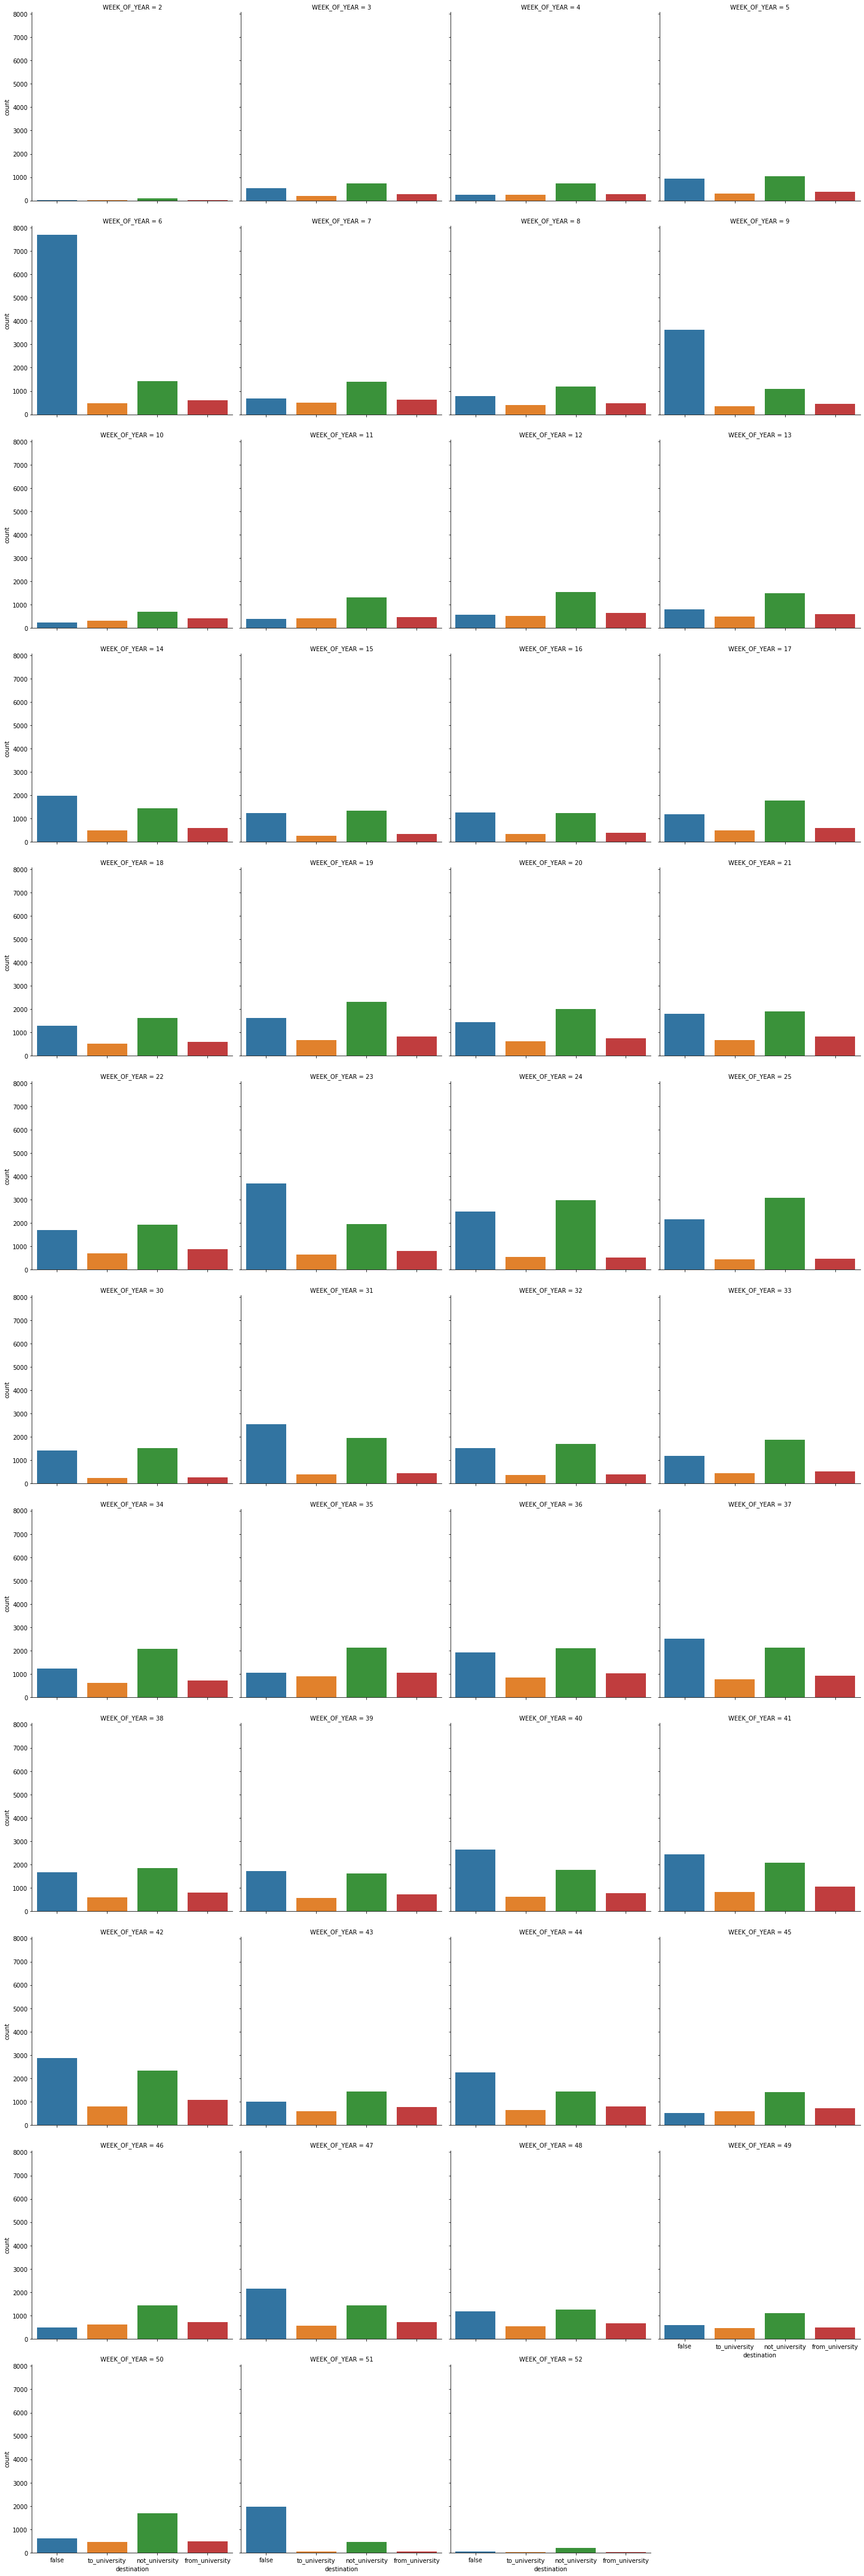

In [11]:
sns.catplot('destination', col='WEEK_OF_YEAR', data=prediction_data, kind='count', col_wrap=4)

# Split

In [12]:
prediction_data

,weekend,is_station,destination,HOUR,WEEK_OF_YEAR,DAY_OF_WEEK,MONTH,season
0,True,True,false,3,36,0,9,3
1,True,True,false,5,36,0,9,3
2,True,True,false,11,36,0,9,3
3,False,False,to_university,8,37,1,9,3
4,False,False,false,11,37,1,9,3
...,...,...,...,...,...,...,...,...
198379,False,True,false,21,51,4,12,0
198380,True,True,false,14,51,6,12,0
198381,True,True,false,22,51,6,12,0
198382,True,True,false,2,51,0,12,0


In [13]:
X = prediction_data.drop(columns=['destination'])
y = prediction_data['destination']

In [14]:
le = preprocessing.LabelEncoder().fit(y)

In [15]:
y = le.transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# RandomForestClassification

In [17]:
rfc = RandomForestClassifier(n_jobs=-1)

In [18]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
y_train_pred = rfc.predict(X_train)

In [20]:
print(metrics.classification_report(le.inverse_transform(y_train_pred), le.inverse_transform(y_train)))

                 precision    recall  f1-score   support

          false       0.73      0.85      0.79     47297
from_university       0.42      0.48      0.45     18595
 not_university       0.80      0.61      0.69     72895
  to_university       0.24      0.42      0.31     10001

       accuracy                           0.66    148788
      macro avg       0.55      0.59      0.56    148788
   weighted avg       0.69      0.66      0.66    148788



# One Vs Rest

In [21]:
from sklearn.multiclass import OneVsRestClassifier

In [22]:
OVR_clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1)).fit(X_train, y_train)

In [23]:
y_train_pred = OVR_clf.predict(X_train)

In [24]:
print(metrics.classification_report(le.inverse_transform(y_train_pred), le.inverse_transform(y_train)))

                 precision    recall  f1-score   support

          false       0.73      0.85      0.79     47233
from_university       0.42      0.48      0.45     18447
 not_university       0.81      0.60      0.69     73261
  to_university       0.24      0.42      0.30      9847

       accuracy                           0.66    148788
      macro avg       0.55      0.59      0.56    148788
   weighted avg       0.70      0.66      0.67    148788



# One Vs One

In [25]:
from sklearn.multiclass import OneVsOneClassifier

In [26]:
OVO_clf = OneVsOneClassifier(RandomForestClassifier(n_jobs=-1)).fit(X_train, y_train)

In [27]:
y_train_pred = OVO_clf.predict(X_train)

In [28]:
print(metrics.classification_report(le.inverse_transform(y_train_pred), le.inverse_transform(y_train)))

                 precision    recall  f1-score   support

          false       0.73      0.85      0.79     47310
from_university       0.42      0.48      0.45     18512
 not_university       0.81      0.60      0.69     73392
  to_university       0.23      0.42      0.30      9574

       accuracy                           0.66    148788
      macro avg       0.55      0.59      0.56    148788
   weighted avg       0.70      0.66      0.67    148788



# Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegressionCV

In [30]:
LR_clf = LogisticRegressionCV(cv=2, random_state=0).fit(X_train, y_train)

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternativ

In [31]:
y_train_pred = LR_clf.predict(X_train)

In [32]:
print(metrics.classification_report(le.inverse_transform(y_train_pred), le.inverse_transform(y_train)))

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          false       0.65      0.40      0.50     89665
from_university       0.00      0.06      0.00       434
 not_university       0.50      0.47      0.49     58689
  to_university       0.00      0.00      0.00         0

       accuracy                           0.43    148788
      macro avg       0.29      0.23      0.25    148788
   weighted avg       0.59      0.43      0.49    148788



# Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
DT_clf = DecisionTreeClassifier().fit(X_train, y_train)

In [35]:
y_train_pred = DT_clf.predict(X_train)

In [36]:
print(metrics.classification_report(le.inverse_transform(y_train_pred), le.inverse_transform(y_train)))

                 precision    recall  f1-score   support

          false       0.74      0.84      0.79     49147
from_university       0.44      0.48      0.46     19500
 not_university       0.80      0.61      0.69     71889
  to_university       0.20      0.43      0.28      8252

       accuracy                           0.66    148788
      macro avg       0.55      0.59      0.55    148788
   weighted avg       0.70      0.66      0.67    148788



# Overall Test Accuracy

In [37]:
y_test_pred = rfc.predict(X_test)

In [38]:
print(metrics.classification_report(le.inverse_transform(y_test_pred), le.inverse_transform(y_test)))

                 precision    recall  f1-score   support

          false       0.71      0.82      0.76     15943
from_university       0.37      0.42      0.39      6147
 not_university       0.76      0.57      0.65     24178
  to_university       0.18      0.31      0.23      3328

       accuracy                           0.62     49596
      macro avg       0.50      0.53      0.51     49596
   weighted avg       0.66      0.62      0.63     49596



# Monthly Differences

In [39]:
test_data=np.concatenate((X_test, np.vstack(y_test)), axis=1)

In [40]:
month_subsets = dict()
for month in prediction_data.MONTH.sort_values().unique():
    month_subsets[month] = test_data[test_data[:,5]==month]

In [41]:
for month, subset in month_subsets.items():
    X = subset[:,:-1]
    y = np.array(subset[:,-1],dtype='int32')
    score = metrics.accuracy_score(le.inverse_transform(y), le.inverse_transform(rfc.predict(X)))
    print('Month: {} \n Accuracy:{}\n'.format(month, score))

Month: 1 
 Accuracy:0.5314787701317716

Month: 2 
 Accuracy:0.6871872960626495

Month: 3 
 Accuracy:0.6193901035673187

Month: 4 
 Accuracy:0.6286498627402046

Month: 5 
 Accuracy:0.5758687258687258

Month: 6 
 Accuracy:0.6351674641148325

Month: 8 
 Accuracy:0.6136363636363636

Month: 9 
 Accuracy:0.6030339185273564

Month: 10 
 Accuracy:0.6246706958004029

Month: 11 
 Accuracy:0.5679156908665105

Month: 12 
 Accuracy:0.6358781024191015



# Seasonal Differences

In [42]:
season_subsets = dict()
for season in prediction_data.season.sort_values().unique():
    season_subsets[season] = test_data[test_data[:,6]==season]

In [43]:
for season, subset in season_subsets.items():
    X = subset[:,:-1]
    y = np.array(subset[:,-1],dtype='int32')
    score = metrics.accuracy_score(le.inverse_transform(y), le.inverse_transform(rfc.predict(X)))
    print('Season: {} \n Accuracy:{}\n'.format(season, score))

Season: 0 
 Accuracy:0.6553231714522038

Season: 1 
 Accuracy:0.6045170970544105

Season: 2 
 Accuracy:0.6257575757575757

Season: 3 
 Accuracy:0.602411091018686



# Weekend Differences

In [44]:
weekend_subsets = dict()
for weekend in prediction_data.weekend.sort_values().unique():
    weekend_subsets[weekend] = test_data[test_data[:,0]==weekend]

In [45]:
for weekend, subset in weekend_subsets.items():
    X = subset[:,:-1]
    y = np.array(subset[:,-1],dtype='int32')
    score = metrics.accuracy_score(le.inverse_transform(y), le.inverse_transform(rfc.predict(X)))
    print('Weekend: {} \n Accuracy:{}\n'.format(weekend, score))

Weekend: False 
 Accuracy:0.6069279854147676

Weekend: True 
 Accuracy:0.65404874564771



# DAY_OF_WEEK

In [46]:
day_subsets = dict()
for day in prediction_data.DAY_OF_WEEK.sort_values().unique():
    day_subsets[day] = test_data[test_data[:,4]==day]

In [47]:
for day, subset in day_subsets.items():
    X = subset[:,:-1]
    y = np.array(subset[:,-1],dtype='int32')
    score = metrics.accuracy_score(le.inverse_transform(y), le.inverse_transform(rfc.predict(X)))
    print('Day: {} \n Accuracy:{}\n'.format(day, score))

Day: 0 
 Accuracy:0.6641414141414141

Day: 1 
 Accuracy:0.5922887612797375

Day: 2 
 Accuracy:0.6088495575221239

Day: 3 
 Accuracy:0.61053276178812

Day: 4 
 Accuracy:0.6057704112952732

Day: 5 
 Accuracy:0.6174027109750765

Day: 6 
 Accuracy:0.6441576807495139



# Hour of Day

In [48]:
hour_subsets = dict()
for hour in prediction_data.HOUR.sort_values().unique():
    hour_subsets[hour] = test_data[test_data[:,2]==hour]

In [49]:
for hour, subset in hour_subsets.items():
    X = subset[:,:-1]
    y = np.array(subset[:,-1],dtype='int32')
    score = metrics.accuracy_score(le.inverse_transform(y), le.inverse_transform(rfc.predict(X)))
    print('Hour: {} \n Accuracy:{}\n'.format(hour, score))

Hour: 0 
 Accuracy:0.7933541017653167

Hour: 1 
 Accuracy:0.8391915641476274

Hour: 2 
 Accuracy:0.8555555555555555

Hour: 3 
 Accuracy:0.8986784140969163

Hour: 4 
 Accuracy:0.8424657534246576

Hour: 5 
 Accuracy:0.6300813008130082

Hour: 6 
 Accuracy:0.552771855010661

Hour: 7 
 Accuracy:0.5233265720081136

Hour: 8 
 Accuracy:0.5795309168443497

Hour: 9 
 Accuracy:0.531960531960532

Hour: 10 
 Accuracy:0.5055986218776917

Hour: 11 
 Accuracy:0.5413274890419537

Hour: 12 
 Accuracy:0.5146676568882287

Hour: 13 
 Accuracy:0.5043417853421327

Hour: 14 
 Accuracy:0.5233644859813084

Hour: 15 
 Accuracy:0.5842665173572228

Hour: 16 
 Accuracy:0.583054965077437

Hour: 17 
 Accuracy:0.6465753424657534

Hour: 18 
 Accuracy:0.6325490196078432

Hour: 19 
 Accuracy:0.6978021978021978

Hour: 20 
 Accuracy:0.732521186440678

Hour: 21 
 Accuracy:0.7385817307692307

Hour: 22 
 Accuracy:0.8060836501901141

Hour: 23 
 Accuracy:0.8056975894813733

